In [150]:
# Similar to the other notebook but the data is sourced directly from the ExpDev API.  See ../expdev07/README.md
import os
import pandas as pd
import json

{'DC': 'District of Columbia', 'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
[('value', Timestamp('2020-02-24 00:00:00')), (

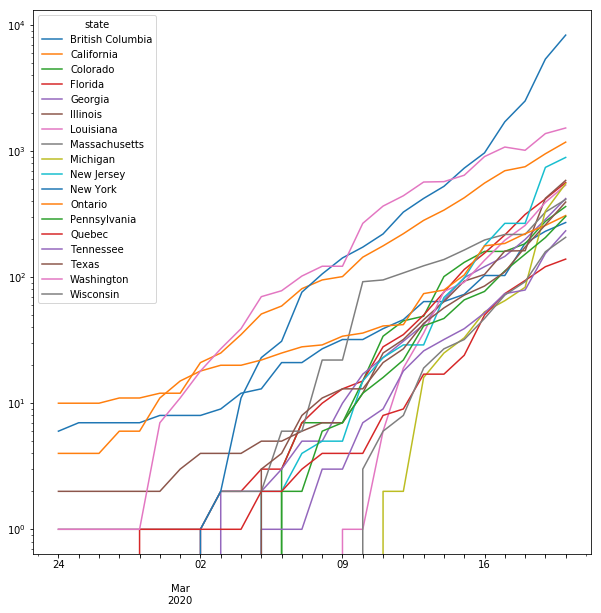

In [151]:
# Load Data
datapath = '../expdev07/all.json'

statecodes = pd.read_csv('../expdev07/statecodes.tsv', sep='\t', names=['code','state'])
statecodes = dict(zip(statecodes['code'],statecodes['state']))
print(statecodes)
df = []
covered = set()
with open(datapath, 'r', encoding='utf-8') as inFh:
    data = json.load(inFh)
    #print(data.keys())
    for row in data['confirmed']['locations']:
        country = row['country']
        province = row['province']
        county = ''
        if ',' in province:
            #print(province)
            (county,state) = province.split(',')
            if state.strip() == 'D.C.':
                pass
            else:
                county=county.strip()
                province = statecodes[state.strip()]
        for h in row['history']:            
            df.append({'country':country, 'state': province,'county':county, 'date': h, 'value':row['history'][h]})
    df=pd.DataFrame(df)

df = df[df['country'].isin(['US','Canada'])]
df.index = pd.to_datetime(df['date'])
maxDate=max(df.index)
del df['date']
del df['country']
#df.sum()
df=df.groupby(['state','date']).sum()
df= df.unstack('date', fill_value=0)
dates = [c for c in df.columns if df[c].max()>10]
print(dates)

df = df[dates].transpose()
   #.swaplevel(axis=1)

#pd.pivot_table(df, values='value', 
#                    columns='state')
#df=df.pivot(columns='state')
#print(df.groupby('province').sum())

    #last_date = list(df.columns)[-1]
    #print(df['Canada'].iloc[-1])
    #print(df.columns)
    #df.index=df['date']
    #del df['Worldwide']
    #del df['International']
print(df.columns)
print(df['Quebec'])
selected = [c for c in df.columns if df[c].iloc[-1]>200 or c=='Quebec']

print(selected)
filtered = df[selected]
df=filtered
df.index = [c[1] for c in df.index]
print(df.index)
df
ax=df.plot(logy=True, xticks=df.index)
#ax.set_xticks(df.index)

In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]

In [153]:
threshold = 30
for c in df.columns:    
    for i,a in enumerate(df[c]):            
        if a>=threshold:
            df[c]=df[c].shift(-i)            
            break
df=df.reset_index(drop=True)
df

state,British Columbia,California,Colorado,Florida,Georgia,Illinois,Louisiana,Massachusetts,Michigan,New Jersey,New York,Ontario,Pennsylvania,Quebec,Tennessee,Texas,Washington,Wisconsin
0,32.0,35.0,34.0,35.0,31.0,32.0,36.0,92.0,33.0,69.0,31.0,34.0,41.0,50.0,32.0,43.0,39.0,32.0
1,32.0,51.0,45.0,50.0,42.0,46.0,77.0,95.0,53.0,98.0,76.0,36.0,47.0,74.0,39.0,57.0,70.0,47.0
2,39.0,59.0,49.0,76.0,66.0,64.0,91.0,108.0,65.0,178.0,106.0,41.0,66.0,94.0,52.0,72.0,78.0,72.0
3,46.0,81.0,101.0,115.0,99.0,93.0,136.0,123.0,83.0,267.0,142.0,42.0,77.0,121.0,74.0,85.0,102.0,92.0
4,64.0,95.0,131.0,155.0,121.0,105.0,196.0,138.0,334.0,267.0,173.0,74.0,112.0,139.0,79.0,110.0,122.0,159.0
5,64.0,101.0,160.0,216.0,146.0,161.0,257.0,164.0,552.0,742.0,220.0,79.0,152.0,NaN,154.0,173.0,122.0,207.0
6,73.0,144.0,160.0,314.0,199.0,162.0,392.0,197.0,NaN,890.0,328.0,104.0,206.0,NaN,233.0,260.0,267.0,NaN
7,103.0,177.0,184.0,417.0,287.0,422.0,538.0,218.0,NaN,NaN,421.0,177.0,303.0,NaN,NaN,394.0,366.0,NaN
8,103.0,221.0,277.0,563.0,420.0,585.0,NaN,218.0,NaN,NaN,525.0,185.0,NaN,NaN,NaN,NaN,442.0,NaN
9,186.0,282.0,363.0,NaN,NaN,NaN,NaN,328.0,NaN,NaN,732.0,221.0,NaN,NaN,NaN,NaN,568.0,NaN


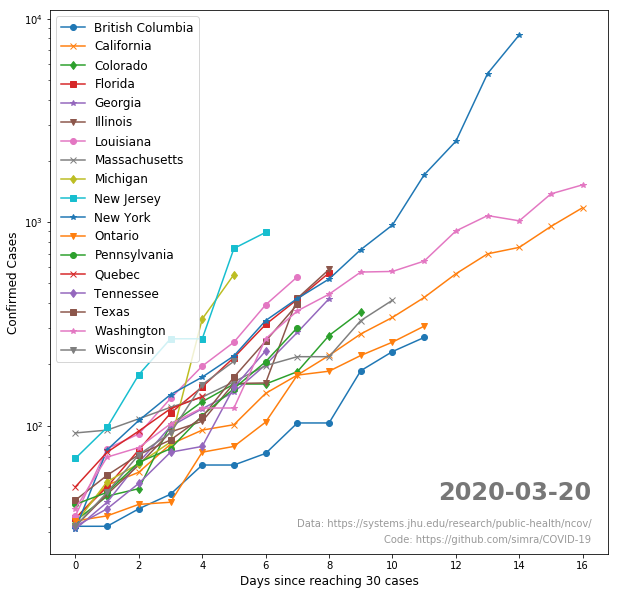

In [154]:
from math import ceil
import matplotlib.font_manager as font_manager
fig, ax = plt.subplots()
markers = [item for sublist in ['oxds*v']*ceil(len(df.columns)/5) for item in sublist]
#df.plot(logy=True, ax=ax) #, ax=ax)
for c,m in zip(df,markers):
    df[c].plot(logy=True, marker=m,  ax=ax)

ax.set_ylabel('Confirmed Cases', size=12)
ax.set_xlabel('Days since reaching {} cases'.format(threshold), size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
ax.legend(prop=font)